In [160]:
import glob
import os
from itertools import product
from IPython.display import display, HTML

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns
import pygal
from pygal.style import RedBlueStyle


from tqdm import tqdm, trange

# MPL Conf Matrix

In [87]:
import matplotlib.font_manager

font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
cambria = [font for font in font_list if ("Eras" in font or "eras" in font)]
cambria

[]

In [107]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = [r"F:\Graphics\Fonts\BalooDa"]
for font in font_manager.findSystemFonts(font_dir):
    # print(font)
    font_manager.fontManager.addfont(font)


In [3]:
def plot_conf(cm, cmap="BuGn", fontname="Times New Roman", labelfontsize=12, tickfontsize=10, 
            labelpad=20, annotsize=10, cellspacing=3, fontspacing=False):
    df_cm = pd.DataFrame(cm, index = [i for i in range(1,11)],
                    columns = [i for i in range(1,11)])
    xtick_labels = ["A"+str(i) for i in range(1,11)]
    if fontspacing:
            xtick_labels = [" ".join(s) for s in xtick_labels]
    rcParams['font.family'] = fontname
    fig = plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap=cmap, xticklabels=xtick_labels, yticklabels=xtick_labels,
                linewidth=cellspacing, annot_kws={"fontsize": annotsize})
    plt.tick_params(length=0, labelsize=tickfontsize)
    xlabel, ylabel = "Actual Activity", "Predicted Activity"
    if fontspacing:
        xlabel = " ".join(xlabel)
        ylabel = " ".join(ylabel)
    plt.xlabel(xlabel, labelpad=labelpad, fontsize=labelfontsize)
    plt.ylabel(ylabel, labelpad=labelpad, fontsize=labelfontsize)
    return fig 

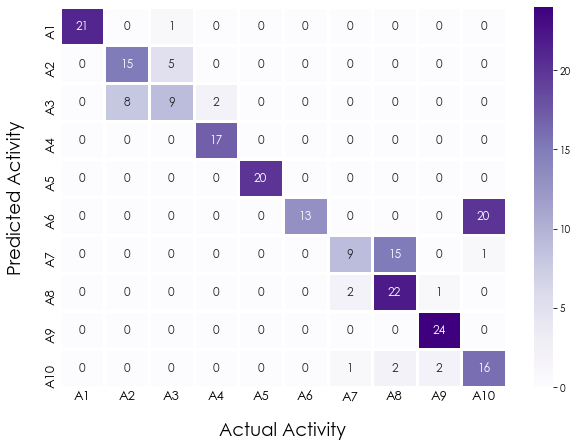

In [106]:
cm = np.load("../plots/conf_matrix.pkl", allow_pickle=True)
fig = plot_conf(cm, "Purples", "Century Gothic", labelfontsize=18, tickfontsize=13, annotsize=12, cellspacing=3)
fig.savefig("plots/loo_confusion_matrix.png", dpi=300)
fig.savefig("plots/loo_confusion_matrix.jpg", dpi=300)

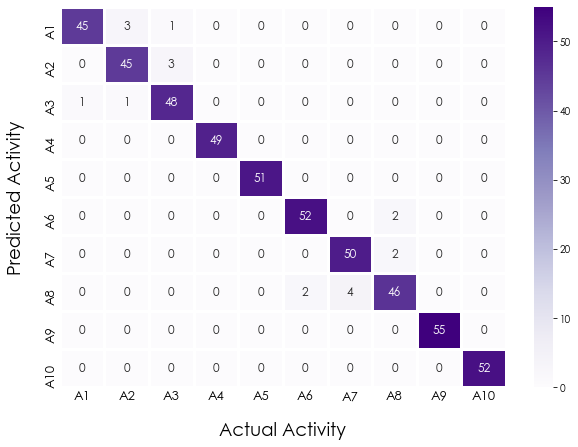

In [5]:
cm = np.load("../plots/cv_conf_matrix.pkl", allow_pickle=True)
fig = plot_conf(cm, "Purples", "Century Gothic", labelfontsize=18, tickfontsize=13, annotsize=12, cellspacing=3)
fig.savefig("../plots/cv_confusion_matrix.png", dpi=300)
fig.savefig("../plots/cv_confusion_matrix.jpg", dpi=300)

# Pygal conf matrix

In [37]:
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))
    return plot_html
    
def plot_cm_pygal(cm):
    labels = list(map(str, (range(1,11))))
    dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
    dot_chart.title = 'Confusion Matrix'
    dot_chart.x_labels = labels
    dot_chart.x_title = "Predicted"
    dot_chart.y_title = "Actual"
    for i in range(len(labels)):
        dot_chart.add(labels[i], cm[i,:])
    return galplot(dot_chart)

In [38]:
cm = np.load("plots/conf_matrix.pkl", allow_pickle=True)
html_plot = plot_cm_pygal(cm)

In [41]:
with open("../pygal_plot.html", "w") as f:
    f.write(html_plot)

# Data and labels

In [91]:
def dataloader():
    labels_count = dict(zip(list(range(1,11)), [0]*10))
    person_data_count = {1:0, 2:0, 3:0, 4:0}
    personwise_label_count = {1:labels_count.copy(), 2:labels_count.copy(), 3:labels_count.copy()}
    # label_persons = dict(zip(list(range(1,11)), [person_data.copy() for _ in range(10)]))
    personwise_duration =  {1:0, 2:0, 3:0, 4:0}
    labelwise_duration = dict(zip(list(range(1,11)), [0]*10))
    personwise_label_duration = {1:labels_count.copy(), 2:labels_count.copy(), 3:labels_count.copy()}
    for path in ["../TrainData/*/*/*.csv", "../TestData/*.csv"]:
        files = tqdm(glob.glob(path))
        for file in files:
            tempdf = pd.read_csv(file)
            person = int(tempdf.loc[0, "subject_id"])
            try:
                activity = tempdf.loc[0, "activity"]
                labels_count[activity] += 1
                labelwise_duration[activity] += len(tempdf)/100
                # label_persons[activity][person] += 1
                personwise_label_count[person][activity] += 1
                personwise_label_duration[person][activity] += len(tempdf)/100

                person_data_count[person] += 1
                personwise_duration[person] += len(tempdf)/100
            except:
                person_data_count[person] += 1
                personwise_duration[person] += len(tempdf)/100
    return (labels_count, personwise_label_count, person_data_count, personwise_duration, 
                labelwise_duration, personwise_label_duration)

In [92]:
(labels_count, personwise_label_count, person_data_count, personwise_duration, 
    labelwise_duration, personwise_label_duration)= dataloader()

100%|██████████| 48/48 [00:02<00:00, 21.81it/s]


In [93]:
personwise_avg_label_duration = personwise_label_duration.copy()
for person,labeldict in personwise_avg_label_duration.items():
    for label,total_duration in labeldict.items():
        personwise_avg_label_duration[person][label] /= personwise_label_count[person][label] 

label_avg_duration = label_duration.copy()
for k,v in label_avg_duration.items():
    label_avg_duration[k] = v/labels_count[k]

person_avg_duration = person_duration.copy()
for k,v in person_avg_duration.items():
    person_avg_duration[k] = v/person_data[k]

In [136]:
color_palletes = [("#191B56", "#6BA6AA", "#A2D2BF"),
                  ("#21aa47", "#0072aa", "#545454")]

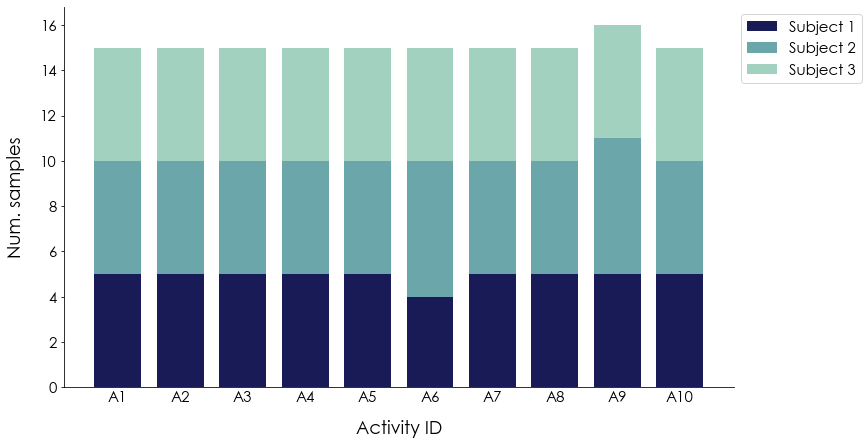

In [171]:
barwidth, labelpad, labelfontsize, tickfontsize, legendfontsize, alpha = 1.5, 15, 18, 15, 15, 1
person1_labels = list(person_labels[1].values())
person2_labels = list(person_labels[2].values())
person3_labels = list(person_labels[3].values())

x = np.arange(2,21, 2)
x_ticks = ["A"+str(i) for i in range(1,11)]

# set the figure size
plt.figure(figsize=(12, 7))
plt.bar(x=x, height=person1_labels, label="Subject 1", color="#191B56", alpha=alpha, width=barwidth)
plt.bar(x=x, height=person2_labels, bottom=person1_labels, label="Subject 2", color="#6BA6AA", alpha=alpha, width=barwidth)
plt.bar(x=x, height=person3_labels, bottom=[i+j for i,j in zip(person1_labels, person2_labels)], 
        label="Subject 3", color="#A2D2BF", alpha=alpha, width=barwidth)
plt.xticks(x, x_ticks, fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.legend(fontsize=legendfontsize, bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel("Num. samples", fontsize=labelfontsize, labelpad=labelpad)
plt.xlabel("Activity ID", fontsize=labelfontsize, labelpad=labelpad)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis="x", length=0)
# show the graph
plt.savefig("../plots/personwise_activity_distribution.png", dpi=300, bbox_inches='tight')
plt.savefig("../plots/personwise_activity_distribution.jpg", dpi=300, bbox_inches='tight')
plt.show()


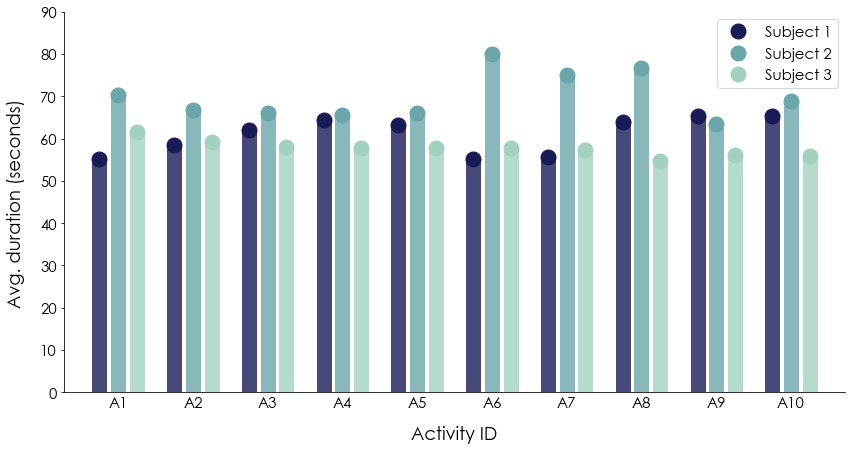

In [141]:
barwidth, labelpad, labelfontsize, tickfontsize, legendfontsize, linewidth, alpha = 1, 15, 18, 15, 15, 15, 0.8
colors = color_palletes[0]
person1_durations = list(personwise_avg_label_duration[1].values())
person2_durations = list(personwise_avg_label_duration[2].values())
person3_durations = list(personwise_avg_label_duration[3].values())

x_ticks = ["A"+str(i) for i in range(1,11)]
x1 = np.arange(4,41, 4)
x2 = [x + barwidth for x in x1]
x3 = [x + barwidth for x in x2]

plt.figure(figsize=(14,7))

plt.vlines(x=x1, ymin=0, ymax=person1_durations, color=colors[0], alpha=alpha, linewidth=linewidth)
plt.plot(x1, person1_durations, "o", markersize=linewidth, color=colors[0], alpha=1, label="Subject 1")

plt.vlines(x=x2, ymin=0, ymax=person2_durations, color=colors[1], alpha=alpha, linewidth=linewidth)
plt.plot(x2, person2_durations, "o", markersize=linewidth, color=colors[1], alpha=1, label="Subject 2")

plt.vlines(x=x3, ymin=0, ymax=person3_durations, color=colors[2], alpha=alpha, linewidth=linewidth)
plt.plot(x3, person3_durations, "o", markersize=linewidth, color=colors[2], alpha=1, label="Subject 3")


plt.xticks(x2, x_ticks, fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.legend(fontsize=legendfontsize)
plt.ylabel("Avg. duration (seconds)", fontsize=labelfontsize, labelpad=labelpad)
plt.xlabel("Activity ID", fontsize=labelfontsize, labelpad=labelpad)
plt.ylim([0,90])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis="x", length=0)
# show the graph
plt.savefig("../plots/personwise_activity_duration.png", dpi=300)
plt.savefig("../plots/personwise_activity_duration.jpg", dpi=300)
plt.show()


# Results

In [145]:
cv_scores = [0.84, 0.92, 0.96, 0.96, 0.94, 0.88, 0.72]
loocv_scores = [0.64,
                0.73,
                0.76,
                0.77,
                0.74,
                0.67,
                0.51]
models = ["Naive Bayes",
            "SVM",
            "RFC",
            "ETC",
            "LGBM",
            "XGB",
            "LSTM"]
score_df = pd.DataFrame({"model": models, "cv_score": cv_scores, "loocv_score": loocv_scores})


In [169]:
x1,x2,x

(array([ 4,  8, 12, 16, 20, 24, 28]),
 array([ 5,  9, 13, 17, 21, 25, 29]),
 array([ 6.5, 12.5, 18.5, 24.5, 30.5, 36.5, 42.5]))

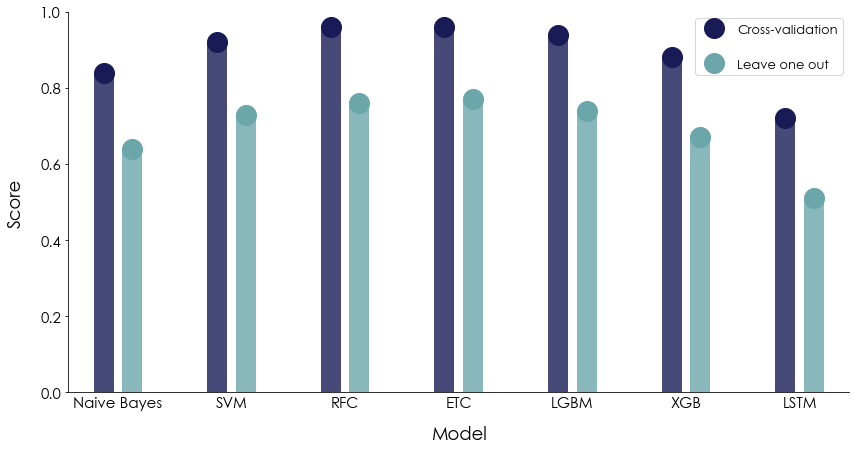

In [170]:
barwidth, labelpad, labelfontsize, tickfontsize, legendfontsize, linewidth, alpha = 1, 15, 18, 15, 13, 20, 0.8
colors = color_palletes[0]

x_ticks = models
x1 = np.arange(4,29, 4)
x2 = np.array([x + barwidth for x in x1])
x = (x1+x2)/2

plt.figure(figsize=(14,7))

plt.vlines(x=x1, ymin=0, ymax=cv_scores, color=colors[0], alpha=alpha, linewidth=linewidth)
a, = plt.plot(x1, cv_scores, "o", markersize=linewidth, color=colors[0], alpha=1, label="Cross-validation")

plt.vlines(x=x2, ymin=0, ymax=loocv_scores, color=colors[1], alpha=alpha, linewidth=linewidth)
b, = plt.plot(x2, loocv_scores, "o", markersize=linewidth, color=colors[1], alpha=1, label="Leave one out")


plt.xticks(x, x_ticks, fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.legend([a,matplotlib.lines.Line2D([],[],linestyle='', linewidth=0.5), b], 
        ["Cross-validation", " ", "Leave one out"], fontsize=legendfontsize, loc="upper right")
plt.ylabel("Score", fontsize=labelfontsize, labelpad=labelpad)
plt.xlabel("Model", fontsize=labelfontsize, labelpad=labelpad)
plt.ylim([0,1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(axis="x", length=0)
# show the graph
plt.savefig("../plots/model_scores.png", dpi=300)
plt.savefig("../plots/model_scores.jpg", dpi=300)
plt.show()
